In [1]:
#|default_exp app

## Gradio Pets

In [2]:
#|export
from fastai.vision.all import *
import gradio as gr
import timm

In [3]:
path = untar_data(URLs.PETS)/'images'

dls = ImageDataLoaders.from_name_func('.',
    get_image_files(path), valid_pct=0.2, seed=42,
    label_func=RegexLabeller(pat = r'^([^/]+)_\d+'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))

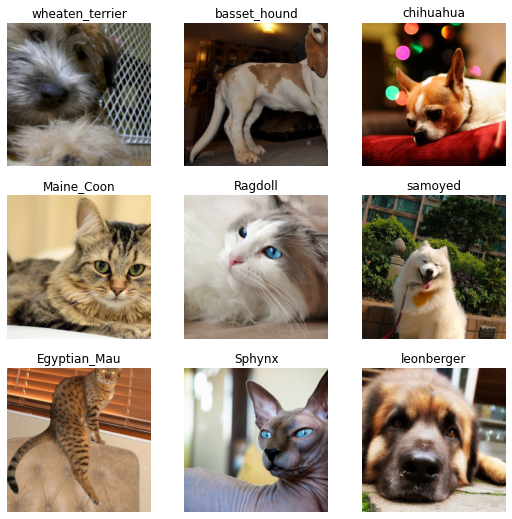

In [4]:
dls.show_batch()

In [5]:
learn2 = vision_learner(dls, resnet34, metrics=error_rate)
learn2.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.532617,0.349670,0.112991,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.473696,0.347469,0.111637,00:15
1,0.331867,0.231770,0.079838,00:15


In [10]:
timm.list_models('beit*')

['beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512']

In [6]:
learn = vision_learner(dls, 'beit_base_patch16_224_in22k', metrics=error_rate)
learn.fine_tune(2)

/home/jhoward/miniconda3/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch,train_loss,valid_loss,error_rate,time
0,3.390269,1.664217,0.472260,00:31


epoch,train_loss,valid_loss,error_rate,time
0,1.043460,0.354510,0.115020,00:40
1,0.533986,0.278076,0.091340,00:40


In [8]:
path = untar_data(URLs.PETS)/'images'

dls = ImageDataLoaders.from_name_func('.',
    get_image_files(path), valid_pct=0.2, seed=42,
    label_func=RegexLabeller(pat = r'^([^/]+)_\d+'),
    item_tfms=Resize(224, method='squish'))

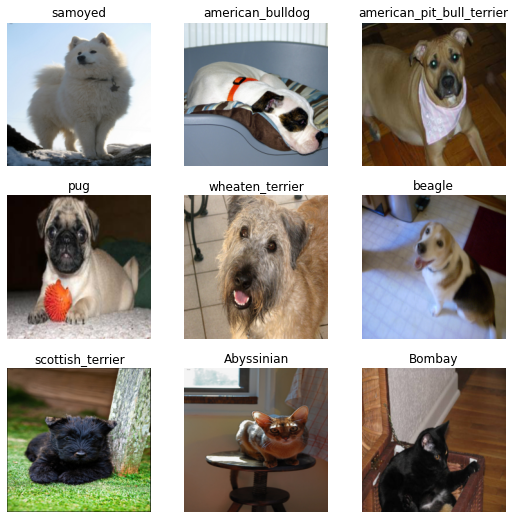

In [8]:
dls.show_batch()

In [9]:
learn = vision_learner(dls, 'beit_base_patch16_224_in22k', metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.176875,0.232042,0.077131,00:27


epoch,train_loss,valid_loss,error_rate,time
0,0.222345,0.203408,0.063599,00:36
1,0.132689,0.173883,0.048714,00:36


In [7]:
learn.export('model.pkl')

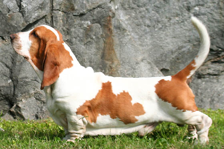

In [10]:
im = PILImage.create('basset.jpg')
im.thumbnail((224,224))
im

In [8]:
#export
learn = load_learner('model.pkl')

In [11]:
learn.predict(im)

('basset_hound',
 TensorBase(14),
 TensorBase([3.6571e-06, 2.7721e-05, 3.9156e-06, 1.5920e-06, 4.5122e-07, 9.9346e-07,
         5.8820e-05, 5.7938e-06, 2.6143e-07, 8.1461e-07, 2.3255e-06, 6.6754e-06,
         8.1900e-06, 5.3273e-05, 9.8933e-01, 9.6509e-03, 2.0291e-05, 4.3530e-08,
         1.2540e-05, 1.7640e-06, 3.8575e-06, 2.4677e-07, 8.2579e-06, 1.5825e-06,
         7.4361e-07, 2.9045e-06, 1.9731e-06, 3.0134e-06, 4.0482e-07, 1.2271e-06,
         7.7483e-04, 2.7283e-06, 6.7284e-07, 1.2830e-07, 1.6467e-07, 1.5092e-06,
         1.2727e-06]))

In [12]:
#export
categories = learn.dls.vocab

def classify_image(img):
    pred,idx,probs = learn.predict(img)
    return dict(zip(categories, map(float,probs)))

In [13]:
classify_image(im)

{'Abyssinian': 3.6570982047123834e-06,
 'Bengal': 2.772147854557261e-05,
 'Birman': 3.915599336323794e-06,
 'Bombay': 1.5919644056339166e-06,
 'British_Shorthair': 4.512166071890533e-07,
 'Egyptian_Mau': 9.934602758221445e-07,
 'Maine_Coon': 5.8819779951591045e-05,
 'Persian': 5.79384914090042e-06,
 'Ragdoll': 2.6143317199966987e-07,
 'Russian_Blue': 8.146108712026034e-07,
 'Siamese': 2.325497689525946e-06,
 'Sphynx': 6.675392342003761e-06,
 'american_bulldog': 8.19001616036985e-06,
 'american_pit_bull_terrier': 5.3273248340701684e-05,
 'basset_hound': 0.9893344044685364,
 'beagle': 0.009650910273194313,
 'boxer': 2.029086863331031e-05,
 'chihuahua': 4.3530494764354444e-08,
 'english_cocker_spaniel': 1.253951541002607e-05,
 'english_setter': 1.7639782754486077e-06,
 'german_shorthaired': 3.857544925267575e-06,
 'great_pyrenees': 2.46769985778883e-07,
 'havanese': 8.257936315203551e-06,
 'japanese_chin': 1.582529421284562e-06,
 'keeshond': 7.436083819811756e-07,
 'leonberger': 2.9045004

In [14]:
#export
image = gr.inputs.Image(shape=(192, 192))
label = gr.outputs.Label()
examples = ['basset.jpg']

In [ ]:
#export
intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)
intf.launch(server_port=3000, inline=False)

In [15]:
intf.close()

Closing server running on port: 3000


In [8]:
import requests,base64
from PIL import Image
from io import BytesIO

In [80]:
def data_url(filename, size=(192,192)):
    image = PILImage.create(filename)
    image.thumbnail(size)
    buff = BytesIO()
    image.save(buff, format="JPEG")
    prefix = f'data:image/{Path(filename).suffix[1:]};base64,'
    return prefix + base64.b64encode(buff.getvalue()).decode('utf-8')

In [91]:
data = {"data": [data_url('cat.jpg')]}
res = requests.post(url='https://hf.space/embed/jph00/testing/+/api/predict/', json=data).json()
res

{'data': [{'label': 'Cat',
   'confidences': [{'label': 'Cat', 'confidence': 1.0},
    {'label': 'Dog', 'confidence': 3.827755170118796e-13}]}],
 'flag_index': None,
 'updated_state': None,
 'durations': [1.636493444442749],
 'avg_durations': [1.2002585530281067]}